<a href="https://colab.research.google.com/github/arjan-hada/protein-variant-prediction/blob/master/03_insilico_directed_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets &> /dev/null

#In-silico directed evolution using Metropolis–Hastings Markov chain Monte Carlo sampling

In the notebooks before this one, we tackled the challenge of understanding the relationship between protein sequences and their functions. We took two different paths: [first notebook](https://github.com/arjan-hada/protein-variant-prediction/blob/master/00_protein_seq2fxn_LLM.ipynb), training a regressor using fixed embeddings of our sequences from a protein language model in transformers, and [second notebook](https://github.com/arjan-hada/protein-variant-prediction/blob/master/01_protein_seq2fxn_finetune_transformers.ipynb), fine-tuning a pretrained protein transformer model with our DMS data.

Now, we're diving into the realm of in-silico directed evolution to navigate the vast protein sequence landscape. Think of it like using a surrogate fitness landscape created by our earlier sequence-to-function model. Our mission here is to implement the Metropolis–Hastings Markov chain Monte Carlo algorithm. This fancy term essentially means we're using a computational method for simulated evolution to propose potentially optimized protein designs.

**Goals**
- Dive into the Metropolis–Hastings Markov chain Monte Carlo (MH MCMC) algorithm for in-silico directed evolution on our surrogate fitness landscape.

## Metropolis– Hastings Markov chain Monte Carlo algorithm

Algorithm description inspired from: https://github.com/SuperSecretBioTech/evolutionary_monte_carlo_search and https://www.nature.com/articles/s41592-021-01100-y

We use a Metropolis–Hastings Markov chain Monte Carlo algorithm. For our in silico directed evolution algorithm we need:
- a. An initial sequence.
- b. A sequence-to-function model that predicts the quantitative function or fitness of an amino acid sequence.
- c. Temperature,
- T. d. Trust radius (the number of mutations relative to WT allowed in proposed designs).

The protocol for the algorithm is as follow:

1. Start with a state sequence $s_{i}$ with fitness $f(s_i)$. Set state sequence s equal to a provided initial sequence.
2. Propose a new sequence $s_{i+1}$ with fitness $f(s_{i+1})$. The new sequence is proposed by randomly adding m ~ Poisson(μ − 1) + 1 mutations to $s_{i}$, where μ is the sequence proposal mutation rate. The sequence proposal mutation rate μ for each trajectory was set to be a random draw from a uniform(1, 2.5) distribution.
3. If $f(s_{i+1})$ > $f(s_i)$ we accept the new sequence and the algorithm starts over.
4. If $f(s_{i+1})$ < $f(s_i)$, we generate a random number from a uniform random distribution and if that number is smaller than for the proposed move, we accept it and start the algorithm again with our new preposed seqeunce. Else we reject the move and start the algorithm over again with the same sequence.

Steps 3. and 4. can be mathematically stated as: accept the proposal and update the state sequence $s_i$ ← $s_{i+1}$, with probability equal to

$$min\left(1, exp\left(\frac{f_s - f_{s-1}}{T}\right)\right),$$

where $exp\left(\frac{f_s - f_{s-1}}{T}\right)$ is the metropolis-hastings criterion, and is usually a number between 0 and 1 for non-optimal moves, the more non-optimal the moves are, the closer that number is to 0. Here, non-optimal simply means a move that decreases the fitness. Note that, if the sequence proposal has more mutations than the input trust radius, its predicted fitness is set, post hoc, to negative infinity, thereby forcing rejection of the proposal.

5. Iterate steps 3 and 4 for a predetermined number of iterations.




Metropolis–Hastings Markov chain Monte Carlo (MH_MCMC) has two main **hyperparameters: temperature and the number of iterations**. Typically, we determine the number of iterations by experimenting with different values and visually inspecting the fitness-versus-iterations plot to find a convergence point with acceptable fitness.

The temperature (called the temperature because that's what the term represents in the boltzmann distribution of energy states at a finite temperature) is the hyperparameter which decides how liberally non-optimal moves are accepted.

The temperature, named so because of its role in the Boltzmann distribution, dictates how generously we accept non-optimal moves. **High temperatures** increase acceptance probabilities, leading to overly explorative trajectories lingering in low predicted fitness areas. Excessively high temperatures, accepting more than 50-60% non-optimal moves, hinder convergence as the algorithm struggles to reject moves near an optimum, favoring broad searches.

Conversely, **low temperatures** reduce acceptance probabilities, resulting in overly exploitative trajectories with consistently increasing fitness traces. Lower temperatures make MH_MCMC more conservative, strictly accepting moves that marginally increase or decrease fitness. This facilitates movement towards an optimum but limits exploration to directions where fitness only increases, akin to an unguided steepest descent algorithm.

Selecting the right temperature is crucial, balancing search depth (exploitation) and breadth (exploration). A common guideline is choosing a temperature that leads to convergence while accepting about 15-20% non-optimal moves during the simulation, though this can vary depending on the problem.

MH_MCMC's strength lies in its simplicity, low computational cost, and ease of debugging/analysis. However, its effectiveness heavily relies on the initial sequence and the local landscape around it, determining whether convergence to a satisfactory fitness occurs.

## Import and setup

In [ ]:
import pickle
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)

Load the protein sequence-to-function model we built in my previous notebook [Learning sequence-to-function relationship using language models](https://github.com/arjan-hada/protein-variant-prediction/blob/master/00_protein_seq2fxn_LLM.ipynb).

In [ ]:
# load sklearn model we built previously
with open('models/bag_emb_esm1v_rep7868aav2.pkl', 'rb') as f: bag_emb_esm1v = pickle.load(f)

In [ ]:
# Check to ensure md5sum of the model is b2adfa4cf9be0b8614ab2b0c6aeee622
!md5sum models/bag_emb_esm1v_rep7868aav2.pkl

b2adfa4cf9be0b8614ab2b0c6aeee622  models/bag_emb_esm1v_rep7868aav2.pkl


## Basic sampling

Here we will run one evolutionary trajectory on rep78 sequence using the MH MCMC algorithm described in the beginning. Each evolutionary trajectory consists of thousands of iterations depending on the length of protein. For basic sampling we need:
 - starting sequence
 - sequence-to-function-model
 - Monte Carlo sampling alongside the Metropolis-Hastings criteria to score and rank-order new sequences

### Starting sequence

In [ ]:
# Wild type sequence of Rep78 from AAV2
rep78_seq = 'MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLNLIEQAPLTVAEKLQRDFLTEWRRVSKAPEALFFVQFEKGESYFHMHVLVETTGVKSMVLGRFLSQIREKLIQRIYRGIEPTLPNWFAVTKTRNGAGGGNKVVDECYIPNYLLPKTQPELQWAWTNMEQYLSACLNLTERKRLVAQHLTHVSQTQEQNKENQNPNSDAPVIRSKTSARYMELVGWLVDKGITSEKQWIQEDQASYISFNAASNSRSQIKAALDNAGKIMSLTKTAPDYLVGQQPVEDISSNRIYKILELNGYDPQYAASVFLGWATKKFGKRNTIWLFGPATTGKTNIAEAIAHTVPFYGCVNWTNENFPFNDCVDKMVIWWEEGKMTAKVVESAKAILGGSKVRVDQKCKSSAQIDPTPVIVTSNTNMCAVIDGNSTTFEHQQPLQDRMFKFELTRRLDHDFGKVTKQEVKDFFRWAKDHVVEVEHEFYVKKGGAKKRPAPSDADISEPKRVRESVAQPSTSDAEASINYADRYQNKCSRHVGMNLMLFPCRQCERMNQNSNICFTHGQKDCLECFPVSESQPVSVVKKAYQKLCYIHHIMGKVPDACTACDLVNVDLDDCIFEQ'
len(rep78_seq)

621

In [ ]:
# change M225G. This will be considered wild type sequence from here on. Python string is zero-indexed
wt_seq = rep78_seq[:224] + 'G' + rep78_seq[225:]
len(wt_seq) # ensure length remains same after substitution

621

### Sequence to function model

In [ ]:
esm1v_checkpoint = "facebook/esm1v_t33_650M_UR90S_1"
# The AutoTokenizer class automatically retrieve the model's configuration, pretrained weights,
# or vocabulary from the name of the checkpoint.
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(esm1v_checkpoint)

# Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method
# to load the weights of a pretrained model
from transformers import AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(esm1v_checkpoint).to(device)

def get_esm1v_rep(rep78_variant):
    """
    Converts rep78 protein sequence variant to fixed dimensional vector
    representation using ESM1v model.

    rep78 sequence variant -> token encodings -> token embeddings ->
    last hidden state -> mean -> fixed-dimensional vector representation
    """
    # encode string and convert the tokens to Pytorch tensors
    tokz = tokenizer(rep78_variant, return_tensors="pt")

    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in tokz.items()
              if k in tokenizer.model_input_names}

    # Extract last hidden states
    with torch.no_grad(): # disable automatic calculation of the gradient for inference
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token and place the final hidden state back on the CPU as NumPy array
    return torch.mean(last_hidden_state, dim=1).cpu().numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm1v_t33_650M_UR90S_1 and are newly initialized: ['esm.pooler.dense.weight', 'esm.contact_head.regression.bias', 'esm.pooler.dense.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def scoring_func(sequence: str):
    """
    scoring function that takes in a string protein sequence, and
    outputs a fitness value.
    """
    # protein sequence to fixed dimensional vector representation using ESM1v model
    seq_repr = get_esm1v_rep(sequence)
    # fixed dimensional vector representation to fitness value
    pred = bag_emb_esm1v.predict(seq_repr)
    return pred[0]

In [ ]:
scoring_func(wt_seq)

0.79098165

In [ ]:
scoring_func(rep78_seq)

0.92150164

### Monte Carlo sampling alongside the Metropolis-Hastings criteria

In [ ]:
from scripts.mh_mcmc_sampler import sample_one_chain

In [ ]:
starter_seq = rep78_seq
sampled_sequences = sample_one_chain(rep78_seq,
                                     starter_seq,
                                     n_steps=10, # n_steps is a hyperparameter
                                     scoring_func=scoring_func,
                                     is_accepted_kwargs={"temperature":0.01},
                                     trust_radius=3)
sampled_seqs_df = pd.DataFrame(sampled_sequences)
sampled_seqs_df

  0%|          | 0/10 [00:00<?, ?it/s]

,sequences,scores,accept
0,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.921502,True
1,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.943941,True
2,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.833681,False
3,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.875992,False
4,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.576772,False
5,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.732222,False
6,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.749478,False
7,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.051466,True
8,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.179487,True
9,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.078296,False


For us a temperature of 0.01 yielded good trajectory behavior - fitness traces improved on average but were not monotonic.  

In [ ]:
from functools import partial
def find_mutated_aa(best_seq, starter_seq):
    """Return aminoacid substitution between two protein sequences of the same length"""
    mutated_aa = [starter_seq[i]+str(i+1)+best_seq[i] for i in range(len(starter_seq))
                  if starter_seq[i] != best_seq[i]]
    return mutated_aa

mut_in_rep78 = partial(find_mutated_aa, starter_seq=rep78_seq)

In [ ]:
sampled_seqs_df['mutated_aa'] = sampled_seqs_df['sequences'].apply(mut_in_rep78)
sampled_seqs_df

,sequences,scores,accept,mutated_aa
0,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.921502,True,[]
1,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.943941,True,[N556I]
2,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.833681,False,"[L454F, N556I]"
3,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.875992,False,"[Q241H, N556I]"
4,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.576772,False,"[I48S, N139V, L157D, N556I]"
5,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.732222,False,"[Q244V, W319L, N556I]"
6,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,0.749478,False,"[Q410G, N556I]"
7,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.051466,True,"[D528T, N556I]"
8,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.179487,True,"[L47V, D528T, N556I]"
9,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.078296,False,"[L47V, S432E, D528T, N556I]"


## Parallel sampling

Here we will run many evolutionary trajectories in parallel.

In [ ]:
# for a given sequence-to-function model, run 3,500 evolutionary trajectories in parallel for 3,000 iterations
from scripts.mh_mcmc_sampler import init_traj_seq, sample_one_chain
import dask

starter_seq = rep78_seq

delayed_results = []

for i in range(10): # sample 3500 independent chains
    #starter_seq = init_traj_seq(rep78_seq, trust_radius=3)
    starter_seq = rep78_seq
    sampled_sequences = dask.delayed(sample_one_chain)(rep78_seq,
                                                       starter_seq,
                                                       n_steps=3000, # 3000 iterations
                                                       scoring_func=scoring_func,
                                                       is_accepted_kwargs={"temperature":0.01},
                                                       trust_radius=3)
    delayed_results.append(sampled_sequences)

results = dask.compute(*delayed_results)

# Convert everything into a single DataFrame
sampled_sequences_df = pd.concat([pd.DataFrame(r) for r in results])

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
def find_best_seq_traj(results):
    """Find the best protein sequence in each evolutionary trajectory."""
    best_seq_traj = []
    for traj, r in enumerate(results):
        df = pd.DataFrame(r)
        df['trajectory'] = traj
        df_accept = df.query('accept == True')
        best_seq_traj.append(df_accept.iloc[[np.argmax(df_accept['scores'].values)]])

    best_seq_traj = pd.concat(best_seq_traj)

    best_seq_traj['mutated_aa'] = best_seq_traj['sequences'].apply(mut_in_rep78)

    return best_seq_traj

Find best protein sequence in each evolutionary trajectory

In [ ]:
# find best protein sequence in each trajectory
traj_01_10 = find_best_seq_traj(results)
traj_01_10

,sequences,scores,accept,trajectory,mutated_aa
1657,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.369083,True,0,"[E75W, E226K, A496K]"
1864,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.213715,True,1,"[L53T, L182F, I524H]"
1187,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.245944,True,2,"[V196I, L276M, A513R]"
2652,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.501488,True,3,"[V134T, G229K, V583G]"
1186,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.465930,True,4,"[K487L, A522Y, Q621I]"
2362,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.822981,True,5,"[N203Y, E510R, G539C]"
1320,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWILPPDSDMDLN...,1.562707,True,6,"[E36I, M597D, V610N]"
2681,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.264632,True,7,"[A56N, R494C, E551W]"
1477,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,1.395800,True,8,"[D468H, D519W, T562P]"
1088,MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPLDSDMDLN...,1.755195,True,9,"[P39L, V215F, D519C]"


In [ ]:
traj_01_10.to_csv('data/traj_01_10.csv')

In [ ]:
sampled_sequences_df.to_csv('data/sampled_sequences.csv')

### Check MCMC trajectories for sampled seqs

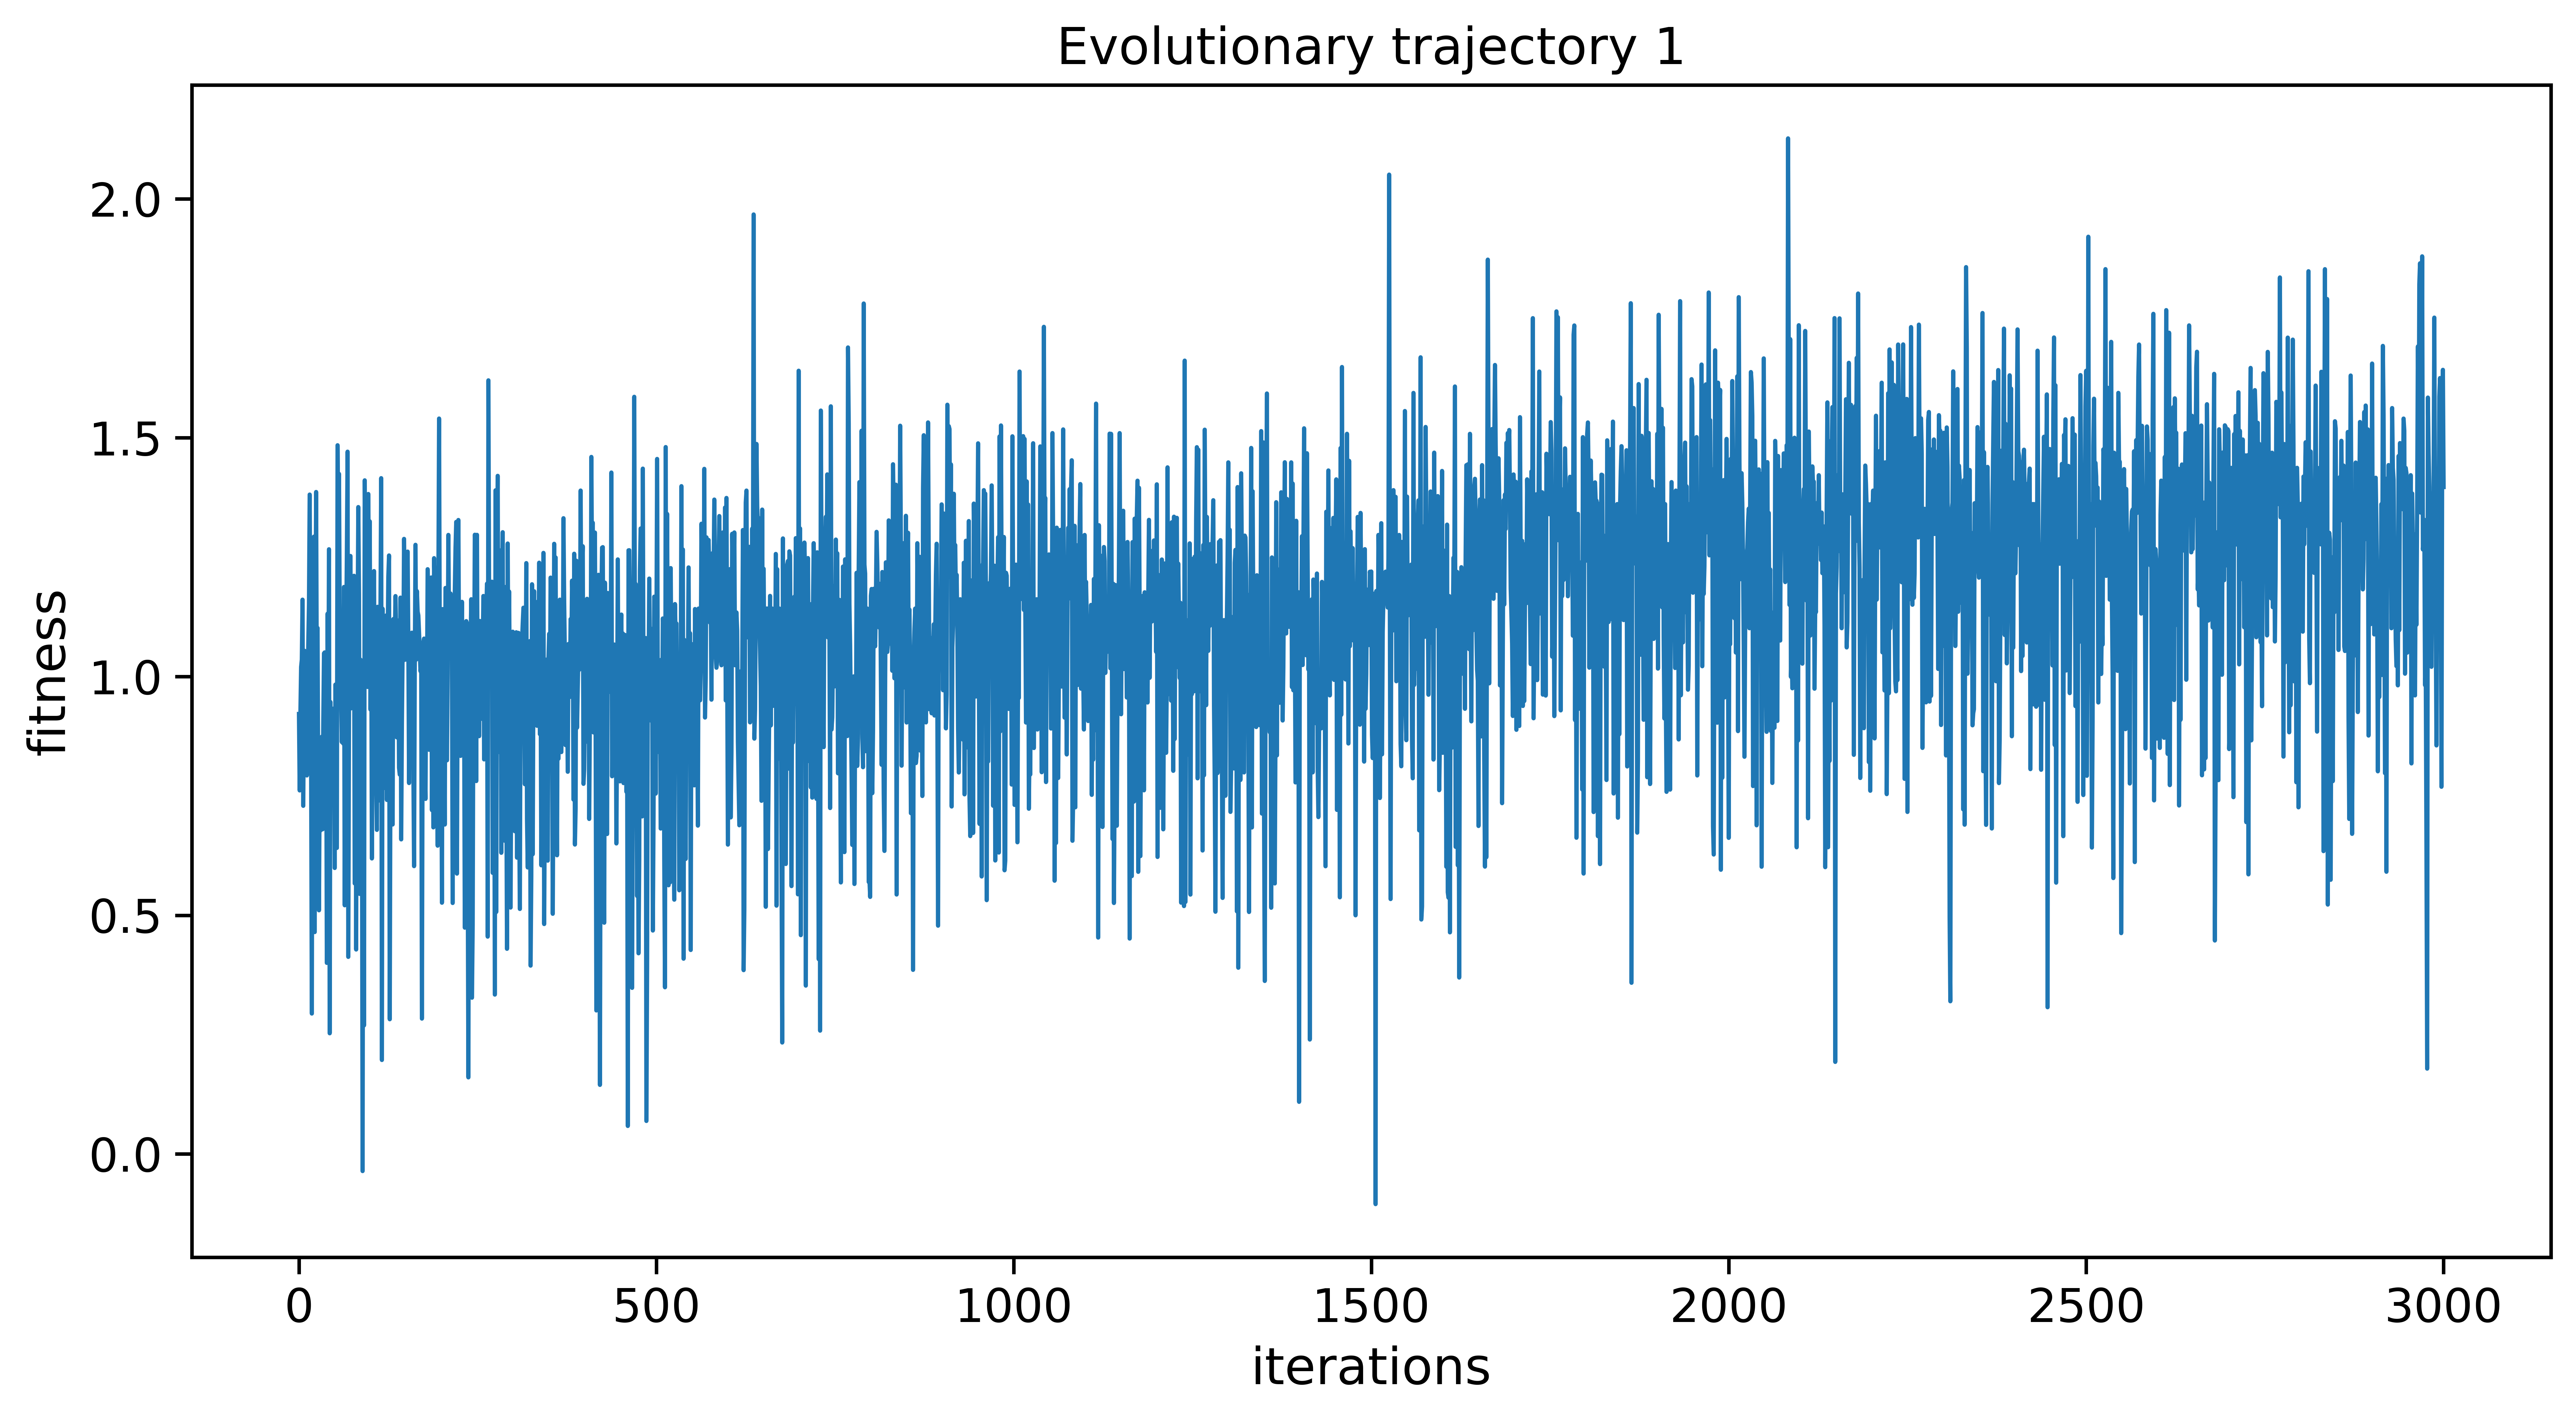

In [ ]:
traj1_scores = results[0]['scores']
# Plot fitness as a function of iterations for one evolutionary trajectory
plt.figure(figsize=(12, 6), dpi=800)
sns.lineplot(traj1_scores)
plt.xlabel('iterations');
plt.ylabel('fitness');
plt.title('Evolutionary trajectory 1');
plt.show()

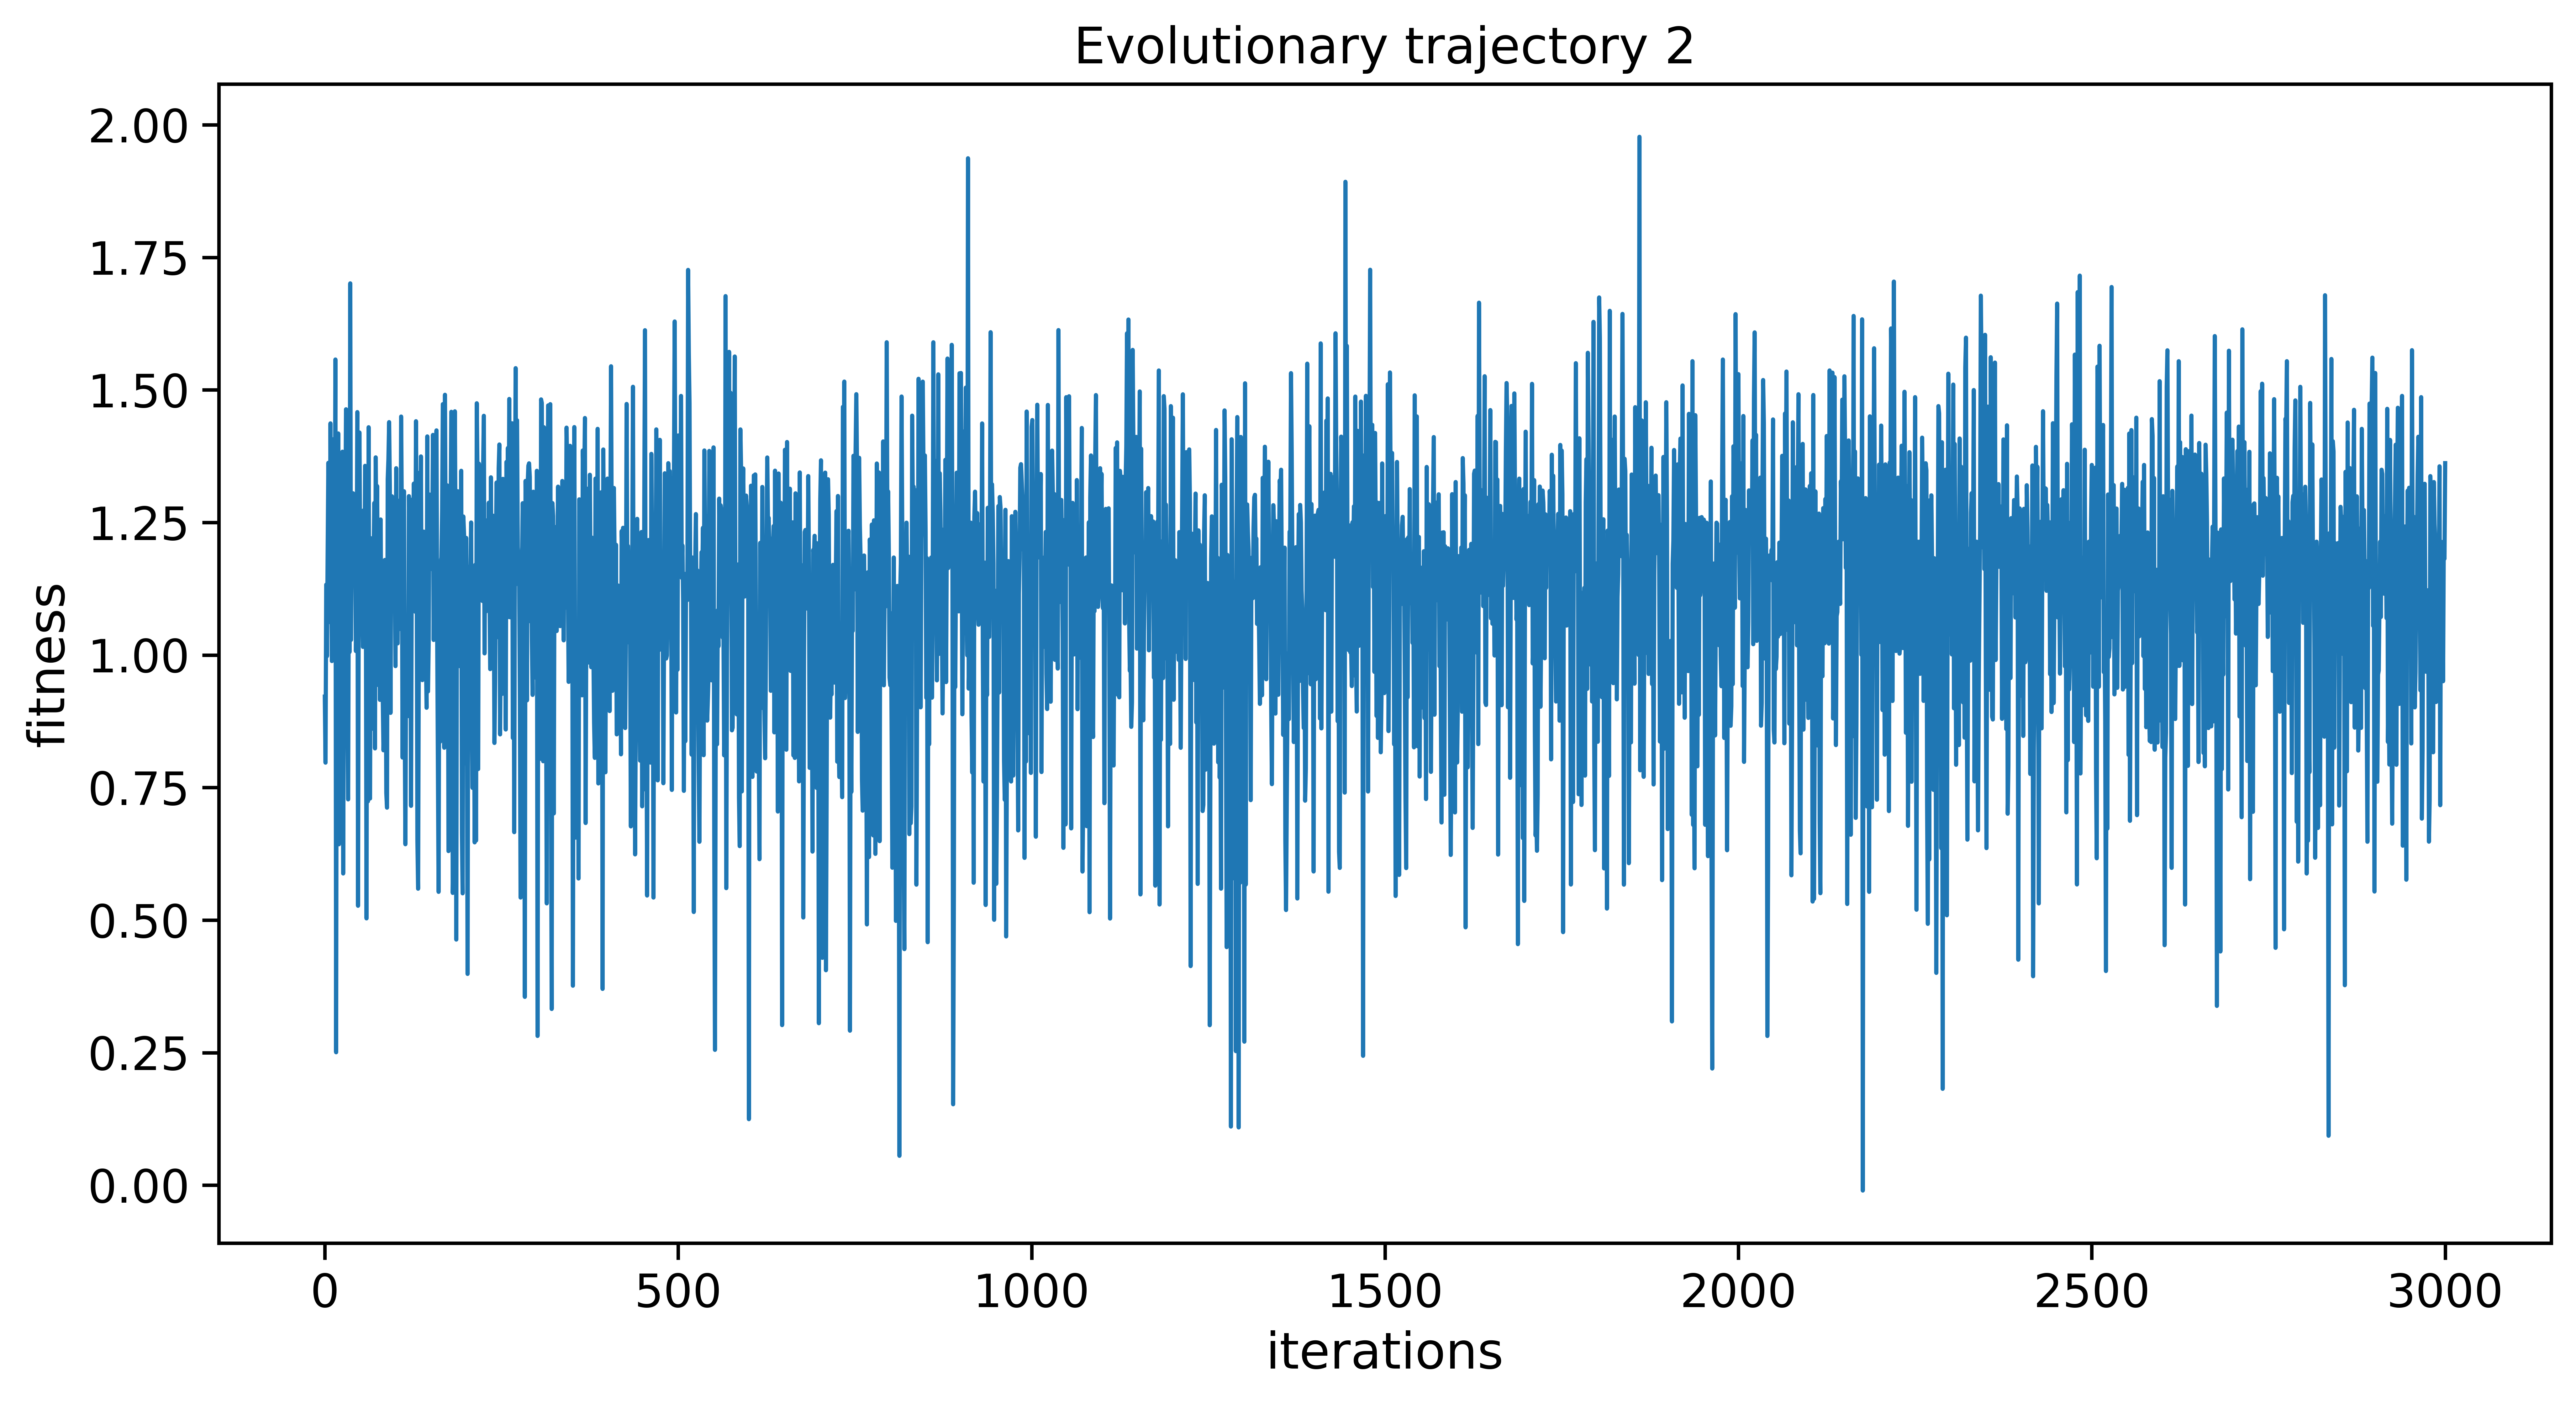

In [ ]:
traj1_scores = results[1]['scores']
# Plot fitness as a function of iterations for one evolutionary trajectory
plt.figure(figsize=(12, 6), dpi=800)
sns.lineplot(traj1_scores)
plt.xlabel('iterations');
plt.ylabel('fitness');
plt.title('Evolutionary trajectory 2');
plt.show()

The fitness traces in evolutionary paths generally improved but weren't consistently increasing, indicating a balanced mix of exploration and exploitation, ensuring effective optimization while exploring diverse options.

## Closing statement


In the quest for high-functioning protein sequences, scientists need to be mindful of the well-known saying, 'you get what you screen for.' This cautionary maxim underscores the risk of overoptimizing a protein's sequence based on functional assays that may not perfectly align with the ultimate design objective. It serves as a reminder to ensure that the screening process aligns closely with the intended goals to avoid unintended consequences in the final design.




